In [1]:
import os 
os.chdir("..")

%load_ext autoreload
%autoreload 2

In [2]:

from numerics.integration.steps import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numerics.utilities.misc import *
import time
from scipy.special import erf
import pickle
import matplotlib

In [3]:
mode = "frequencies"

In [4]:
def load_liks(itraj, mode="damping", dtt=1e-6, total_time_in=6.):
    pars = give_def_params_discrimination(flip=0, mode = mode)
    params, exp_path = check_params_discrimination(pars)
    [gamma1, omega1, n1, eta1, kappa1], [gamma0, omega0, n0, eta0, kappa0] = params
    logliks =load_data_discrimination_liks(itraj=itraj, total_time = total_time_in, dt=dtt, exp_path = exp_path)
    l1  = logliks[:,0] - logliks[:,1]
    
    pars = give_def_params_discrimination(flip=1, mode = mode)
    params, exp_path = check_params_discrimination(pars)
    [gamma1, omega1, n1, eta1, kappa1], [gamma0, omega0, n0, eta0, kappa0] = params
    logliks =load_data_discrimination_liks(itraj=itraj, total_time = total_time_in, dt=dtt, exp_path = exp_path)
    l0  = logliks[:,1] - logliks[:,0]
      
    return l0, l1

In [5]:
dtt = 1e-6
T = 50.#
ppp=1e4

In [6]:
pars = give_def_params_discrimination(flip=0, mode = mode)
params, exp_path = check_params_discrimination(pars)
[gamma1, omega1, n1, eta1, kappa1], [gamma0, omega0, n0, eta0, kappa0] = params

total_time, dt = get_total_time_dt(params, dt=dtt, total_time=T, ppp=1e4)

times = np.arange(0, total_time+ dt, dt)


indis = np.logspace(1,np.log10(len(times)-1), 1000)
indis = [int(k) for k in indis]
timind = [times[ind] for ind in indis]





Ntraj = 1000
boundsB= np.arange(-4,8.1,.2)


stop = {}
stop["_0"] = {i:[] for i in range(1,Ntraj)}
stop["_1"] = {i:[] for i in range(1,Ntraj)}


er=[]
deter = {}
deter["h0/h1"] ={indb:[0]*len(indis) for indb in range(len(boundsB))}
deter["h1/h0"] = {indb:[0]*len(indis) for indb in range(len(boundsB))}

l0,l1 = np.zeros((2,len(times)+1))

deter_data_h0_h1 = np.zeros((Ntraj, len(boundsB), len(indis)))#{indb:{ind:[] for ind in indis} for indb in range(len(boundsB))}#["h1/h0"] = {indb:[0]*len(indis) for indb in range(len(boundsB))}
deter_data_h1_h0 = np.zeros((Ntraj, len(boundsB), len(indis)))##{indb:{ind:[] for ind in indis} for indb in range(len(boundsB))}#["h1/h0"] = {indb:[0]*len(indis) for indb in range(len(boundsB))}



n=1
ers = []
for itraj in tqdm(range(1,1000)):
    try:

        log_lik_ratio, log_lik_ratio_swap = load_liks(itraj=itraj, mode=mode, dtt=dt, total_time_in=total_time)
        for indb,b in enumerate(boundsB):
            if b>=0:
                stop["_1"][itraj].append(get_stop_time(log_lik_ratio, b, times))
                stop["_0"][itraj].append(get_stop_time(log_lik_ratio_swap, b,times))

            for ind, time_index in enumerate(indis):
                deter_1 = log_lik_ratio[time_index] < b
                deter_0 = log_lik_ratio_swap[time_index] > b


                deter_data_h0_h1[itraj][indb][ind] = deter_1
                deter_data_h1_h0[itraj][indb][ind] = deter_0

                deter["h0/h1"][indb][ind] +=  (int(deter_1) - deter["h0/h1"][indb][ind] )/n
                deter["h1/h0"][indb][ind] += (int(deter_0) - deter["h1/h0"][indb][ind])/n
        l1= l1 + log_lik_ratio
        l0 = l0 +log_lik_ratio_swap
        n+=1
    except Exception:
        ers.append(itraj)
        pass
l0/=(Ntraj - len(ers))
l1/=(Ntraj - len(ers))


100%|██████████| 999/999 [02:20<00:00,  7.13it/s]


In [7]:
bpos = boundsB[boundsB >=0]
bneg = boundsB[boundsB <0]

stops0 = [[] for k in range(len(bpos))]
stops1 = [[] for k in range(len(bpos))]

values1 = list(stop["_1"].values())
values0 = list(stop["_0"].values())

for k,val in enumerate(values1):
    if len(val)>2:
        for indb in range(len(val)):
            if ~np.isnan([values1[k][indb]])[0] == True:
                stops1[indb].append(np.squeeze(values1[k][indb]))
        
for k,val in enumerate(values0):
    if len(val)!=0:
        for indb in range(len(val)):
            if ~np.isnan([values0[k][indb]])[0] == True:
                stops0[indb].append(np.squeeze(values0[k][indb]))


In [8]:
                
cons1, cons0 = [], []
anals1, anals0 = [], []
timbin0, timbin1 = [], []
for indb, b in enumerate(boundsB[int(len(boundsB)/2):]):
    counts1, bins1 = np.histogram(stops1[indb], 50, normed=True)
    counts0, bins0 = np.histogram(stops0[indb], 50, normed=True)
    
    timms1 = np.linspace(0,np.max(bins1), 100)
    timms0 = np.linspace(0,np.max(bins0), 100)
    
    timbins1 = .5*(bins1[1:] + bins1[:-1])
    timbins0 = .5*(bins0[1:] + bins0[:-1])
    
    cons1.append(counts1)
    cons0.append(counts0)
    
    timbin1.append(timbins1)
    timbin0.append(timbins0)
    
    gp1 =[prob(t, b, kappa0, kappa1, eta0 , eta1, n0, n1, gamma0, gamma1)[0] for t in timms1]
    anals1.append(gp1)
    
    gp0 = [prob(t, b, kappa1, kappa0, eta1 , eta0, n1, n0, gamma1, gamma0)[0] for t in timms0]
    anals0.append(gp0)
    

<ipython-input-8-dd155c07152b>:5: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  counts1, bins1 = np.histogram(stops1[indb], 50, normed=True)
<ipython-input-8-dd155c07152b>:6: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  counts0, bins0 = np.histogram(stops0[indb], 50, normed=True)
/home/giq/Desktop/continuous/numerics/utilities/misc.py:153: RuntimeWarning: divide by zero encountered in dou

NOW PLOT!

In [135]:
mode = "frequencies"
pars = give_def_params_discrimination(flip=0, mode = mode)
params, exp_path = check_params_discrimination(pars)
[gamma1, omega1, n1, eta1, kappa1], [gamma0, omega0, n0, eta0, kappa0] = params



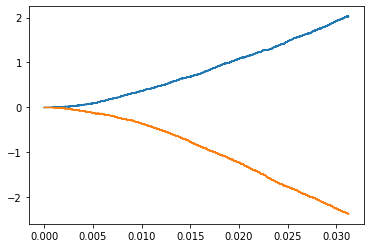

In [15]:
plt.plot(times,l1[:-1])
plt.plot(times,l0[:-1])

In [16]:

    
alphas = list(deter["h0/h1"].values())
betas = list(deter["h1/h0"].values())

alphas = np.stack(alphas)
betas = np.stack(betas)

bpos = boundsB[boundsB>=0]
bneg = boundsB[boundsB<0]

avg_err_alpha = lambda o: (1-np.exp(-abs(o)))/(np.exp(abs(o)) - np.exp(-abs(o)))
avg_err_beta = lambda o :(1-np.exp(-abs(o)))/(np.exp(abs(o)) - np.exp(-abs(o)))

errs = np.array([avg_err_alpha(b) for b in boundsB]) #
tot_err = 0.5*(alphas+betas)#0.5*(alphas + betas)
times_to_errs = [timind[np.argmin(np.abs(tot_err[indb,:] - errs[indb]))] for indb in range(len(bpos))]



stops0 = [[] for k in range(len(bpos))]
stops1 = [[] for k in range(len(bpos))]

values1 = list(stop["_1"].values())
values0 = list(stop["_0"].values())
for k,val in enumerate(values1):
    if len(val)!=0:
        for indb in range(len(val)):
            if ~np.isnan([values1[k][indb]])[0] == True:
                stops1[indb].append(np.squeeze(values1[k][indb]))
        
for k,val in enumerate(values0):
    if len(val)!=0:
        for indb in range(len(val)):
            if ~np.isnan([values0[k][indb]])[0] == True:
                stops0[indb].append(np.squeeze(values0[k][indb]))


avg_times1 = np.array([np.mean(k) for k in stops1])
avg_times0 = np.array([np.mean(k) for k in stops0])

std_times1 = np.array([np.std(k) for k in stops1])
std_times0 = np.array([np.std(k) for k in stops0])
avg_times = 0.5*(avg_times0 + avg_times1)

std_times = np.sqrt(std_times1**2   + std_times0**2)#0.5*(np.array(avg_times0) + np.array(avg_times1) )
stoch = avg_times
stoch_std = std_times


avg_err_alpha = lambda o: (1-np.exp(-o))/(np.exp(o) - np.exp(-o))
errs = [avg_err_alpha(b) for b in bpos]
times_alpha_to_errB = [timind[np.argmin(np.abs(alphas[indb+len(bneg),:]+betas[len(bneg)-indb+1,:] - errs[indb]))] for indb in range(len(bpos))]

In [17]:
avg_err_alpha = lambda o: (1-np.exp(-o))/(np.exp(o) - np.exp(-o))
b_to_ep = lambda o: (1-np.exp(-abs(o)))/(np.exp(abs(o)) - np.exp(-abs(o)))

errs = [avg_err_alpha(b) for b in bpos]
times_alpha_to_errB = [timind[np.argmin(np.abs(alphas[indb+len(bneg),:]+betas[len(bneg)-indb+1,:] - errs[indb]))] for indb in range(len(bpos))]

In [34]:
bb = np.linspace(0,100,1000)
stop_avg_1, stop_avg_0 = [], []
for indb,b in enumerate(bb):
    if b>=0:
        stop_avg_1.append(get_stop_time(l1, b, times))
        stop_avg_0.append(get_stop_time(l0, b,times))

In [42]:
times[-1]

0.03125962839392828

In [41]:
np.where(stop_avg_1

[nan,
 0.0053365187208978615,
 0.007067114268042519,
 0.008813464667897716,
 0.010469849857235189,
 0.01221144879357451,
 0.013634324558809337,
 0.01527407962584124,
 0.016563476777833992,
 0.01765531307837712,
 0.019037113691902325,
 0.020222853916140815,
 0.021679490080041084,
 0.023260414526435614,
 0.024310362924930877,
 0.02533292788895306,
 0.026526107904749303,
 0.027673523824576832,
 0.028909904646813485,
 0.029801804364149045,
 0.030883450025835753,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 na

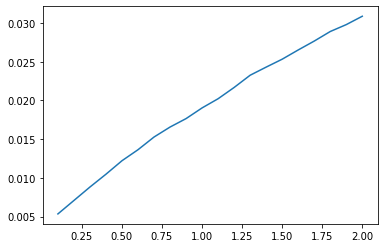

In [39]:
ax=plt.subplot(111)
ax.plot(bb,stop_avg_1)

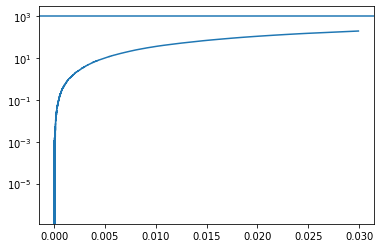

In [142]:
ax=plt.subplot(111)
ax.plot(times,l1[:-1])
for k in bb[:-2:-1]:
    ax.axhline(k)
ax.set_yscale("log")

In [45]:
bb = np.linspace(0,1000,100)
stop_avg_1, stop_avg_0 = [], []
for indb,b in enumerate(boundsB):
    if b>=0:
        stop_avg_1.append(get_stop_time(l1, b, times))
        stop_avg_0.append(get_stop_time(l0, b,times))

In [48]:
params

[[100, 10100.0, 1, 1, 1000000.0], [100, 10000.0, 1, 1, 1000000.0]]

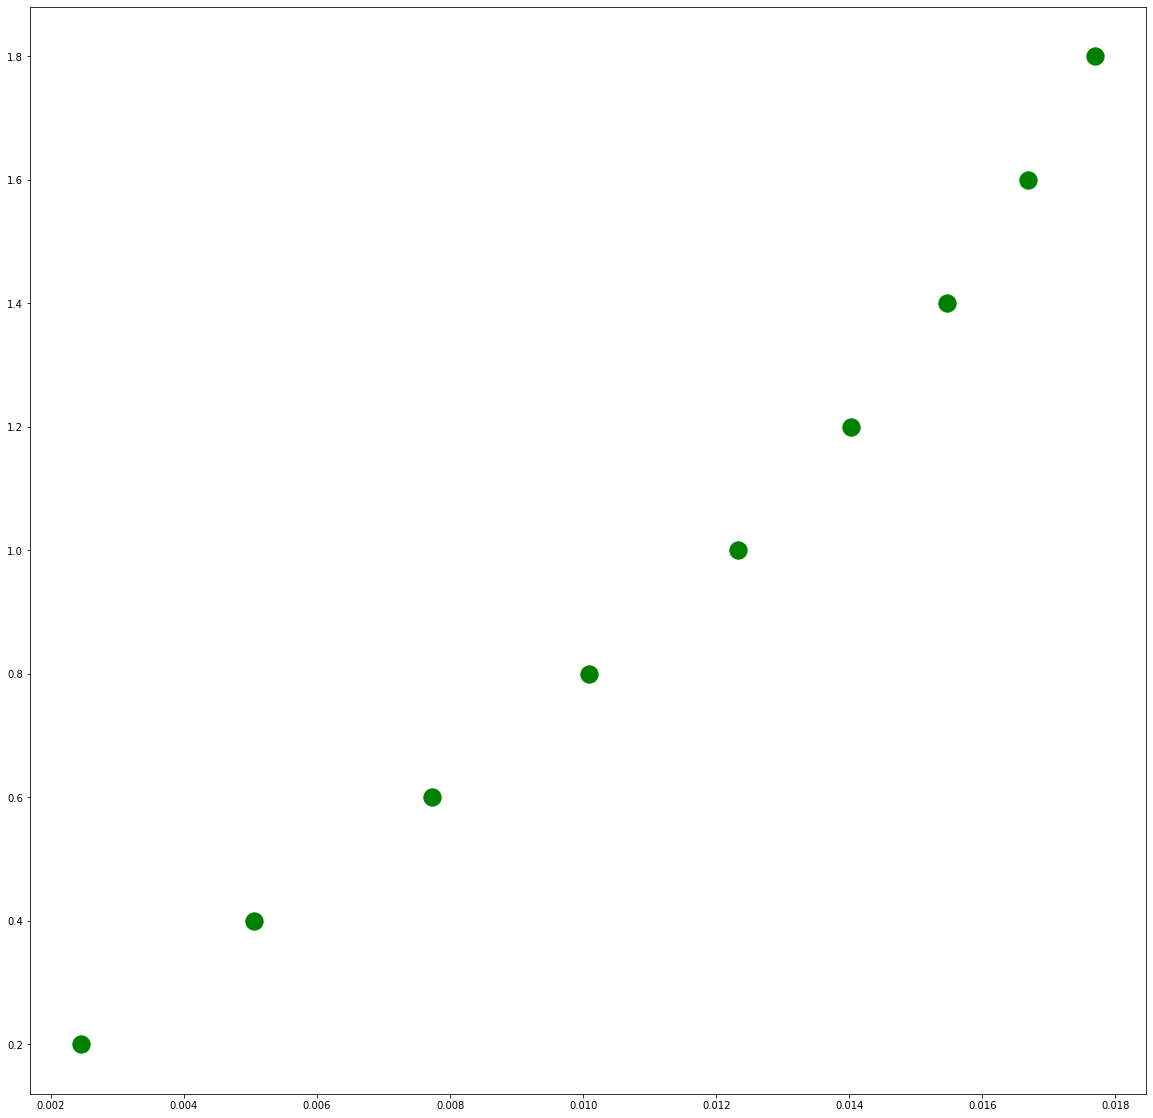

In [97]:
A = 10
AA = 1
plt.figure(figsize=(20,20))
ax = plt.subplot(111)
ax.scatter(stoch[AA:A], boundsB[boundsB>0][AA:A],s=300, label="avg of stop time", color="green")


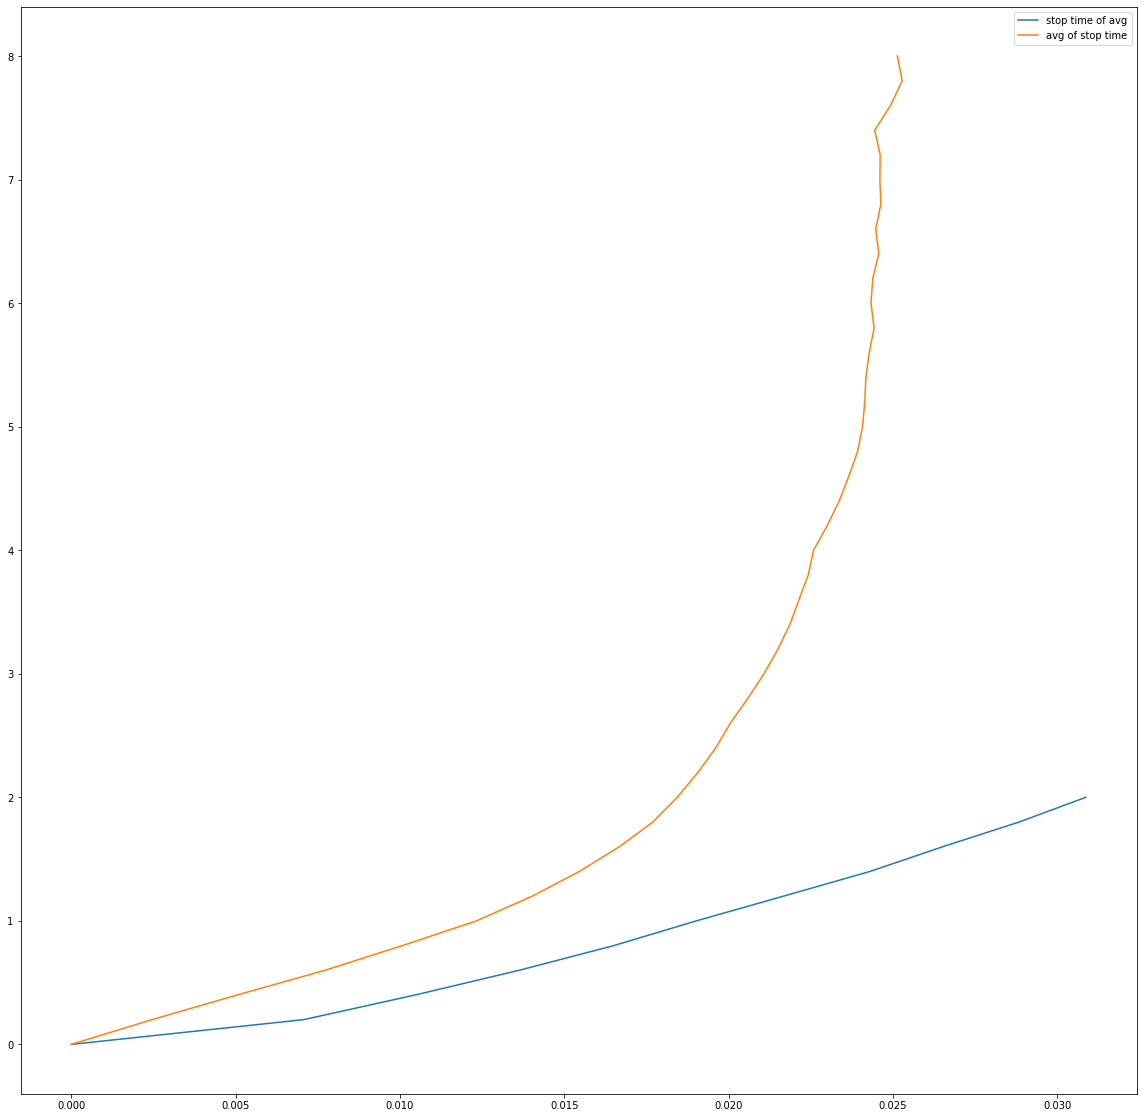

In [83]:
plt.figure(figsize=(20,20))
plt.plot(stop_avg_1[:A], boundsB[boundsB>0][:A], label="stop time of avg")
plt.plot(stoch, boundsB[boundsB>0], label="avg of stop time")
plt.legend()

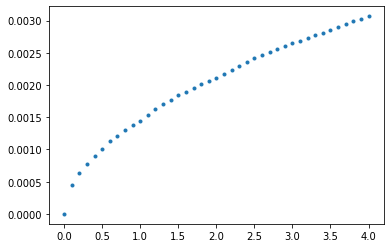

In [145]:
plt.plot(boundsB[boundsB>0], stop_avg_1,'.')

In [155]:
timbin1[-1][-1]/times[-1]

0.56613904

In [153]:
timbin1[-1][-1]

0.016938840466422647

In [157]:
b_to_ep(bpos[-1])

0.017986209962091434

In [158]:
b_to_ep(8)

0.0003353501304664781

In [119]:
ll1={}
ll0={}
for k in range(1,5):
    ll1[k], ll0[k] = load_liks(itraj=k, mode="frequencies", dtt=dt, total_time_in=total_time)
    

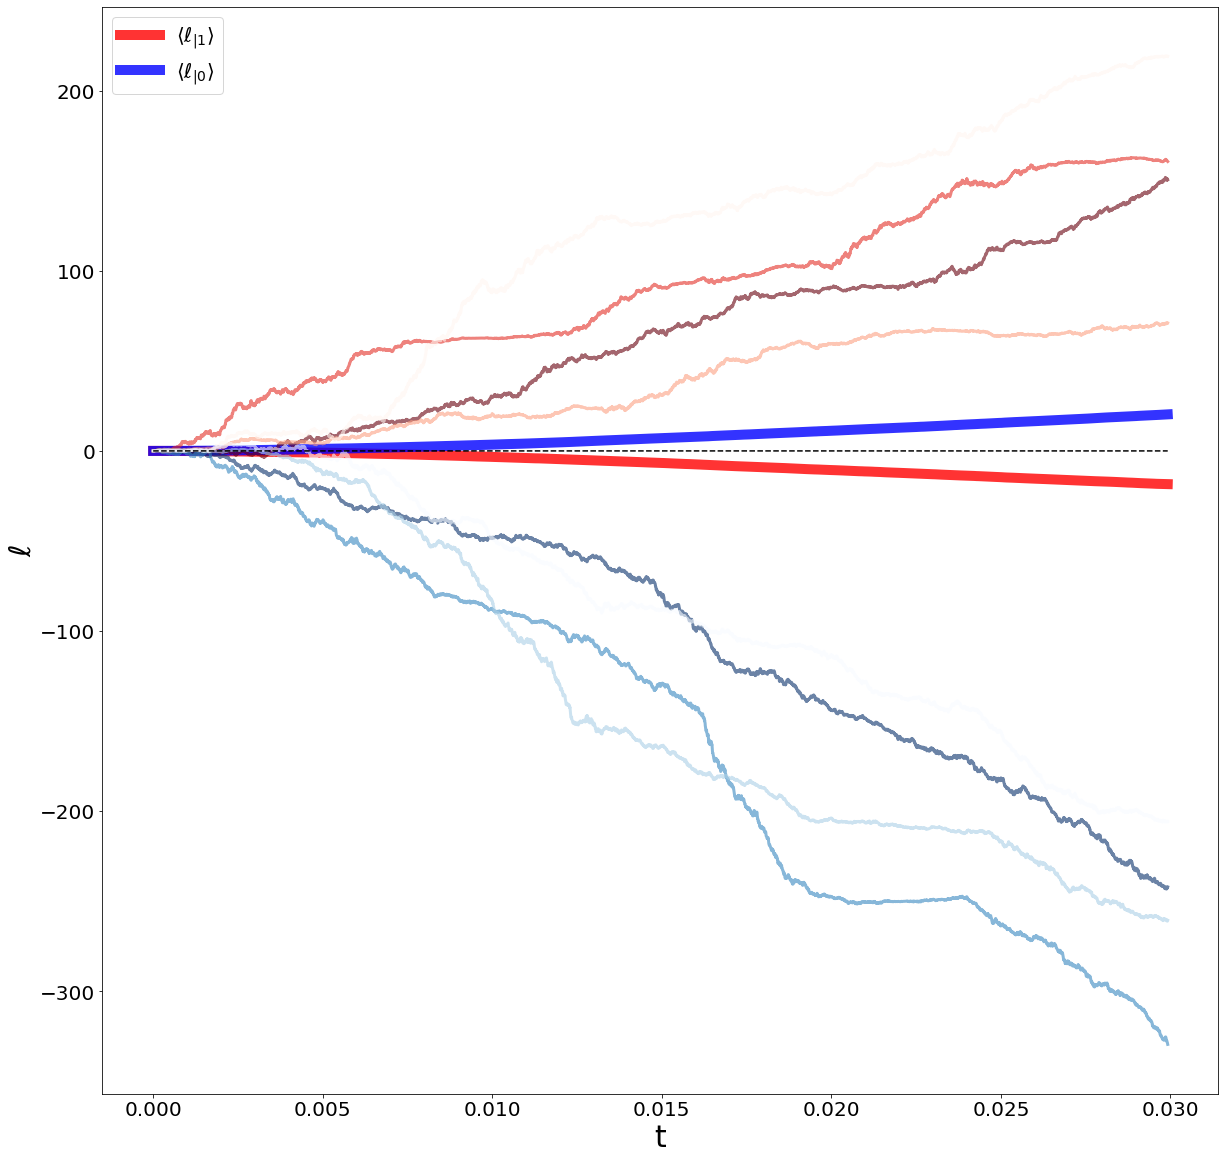

In [120]:
colors1 = plt.get_cmap("Reds")
colors0 = plt.get_cmap("Blues")
Ntraj = 4
Ltraj=3
LS=30
c1 = colors1(np.linspace(0,1,Ntraj))[::-1]
c0 = colors0(np.linspace(0,1,Ntraj))[::-1]

jump = 100
plt.figure(figsize=(20,20))
ax=plt.subplot(111)
ax.plot(times[::jump],l0[:-1][::jump], color="red", alpha=0.8, linewidth=10, label=r'$\langle \ell_{|1} \rangle$')
ax.plot(times[::jump],l1[:-1][::jump], color="blue", alpha=0.8, linewidth=10, label=r'$\langle \ell_{|0} \rangle$')
for ind,k in enumerate(range(1,5)):
    ax.plot(times[::jump],ll1[k][:-1][::jump], color=c1[ind], linewidth=Ltraj, alpha=0.6)
    ax.plot(times[::jump],ll0[k][:-1][::jump], color=c0[ind], linewidth=Ltraj, alpha=0.6)   
ax.plot(times[::jump], np.zeros(len(times))[::jump], '--', color="black")
ax.set_xlabel("t", size=LS)
ax.set_ylabel(r'$\ell$', size=LS)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(prop={"size":20})


In [51]:
boundsB[-20]

4.200000000000006

In [67]:
b = boundsB[indb]
b_to_ep(b)

0.09975048911968466

0.017986209962091434


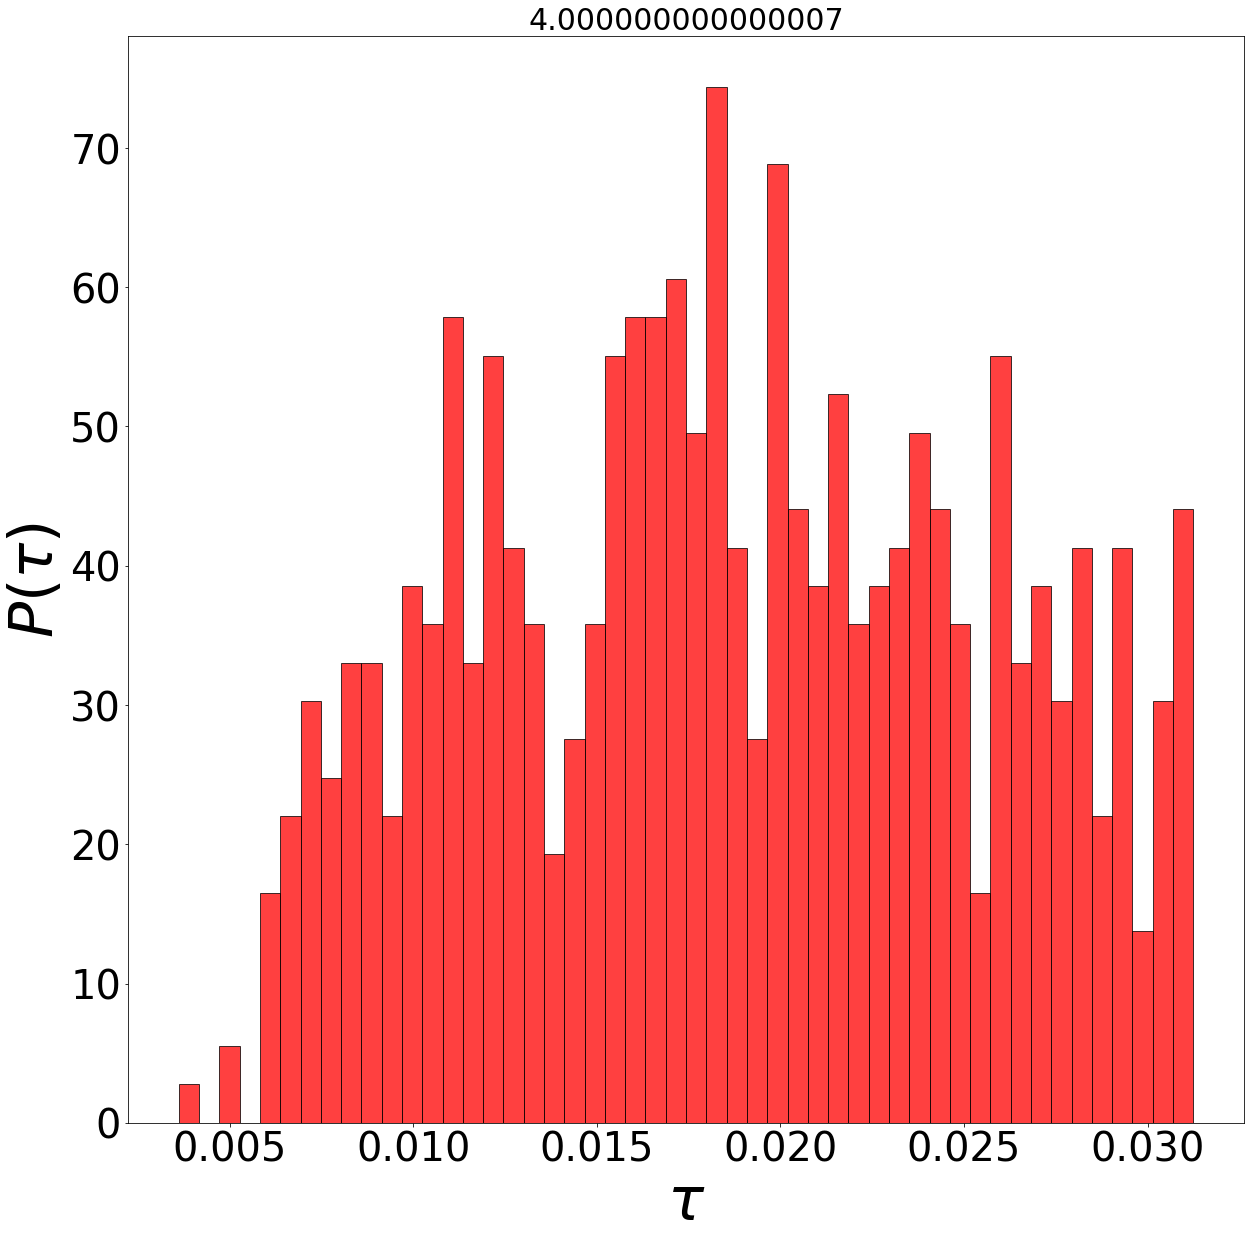

In [82]:
LS, TS = 60, 40
plt.figure(figsize=(20,20))
ax = plt.subplot(111)
indb = -21
b = boundsB[indb]
print(b_to_ep(b))
ax.set_title(str(boundsB[indb]), size=30)
ax.bar(timbin1[indb], cons1[indb], width=timbin1[indb][1]-timbin1[indb][0], color="red", alpha=0.75, edgecolor="black",)#, label="simulations")
ax.set_xlabel(r'$\tau$',size=LS)
ax.set_ylabel(r'$P(\tau)$', size=LS)
ax.tick_params(axis='both', which='major', labelsize=TS)

In [70]:
times[-1]

0.03125962839392828

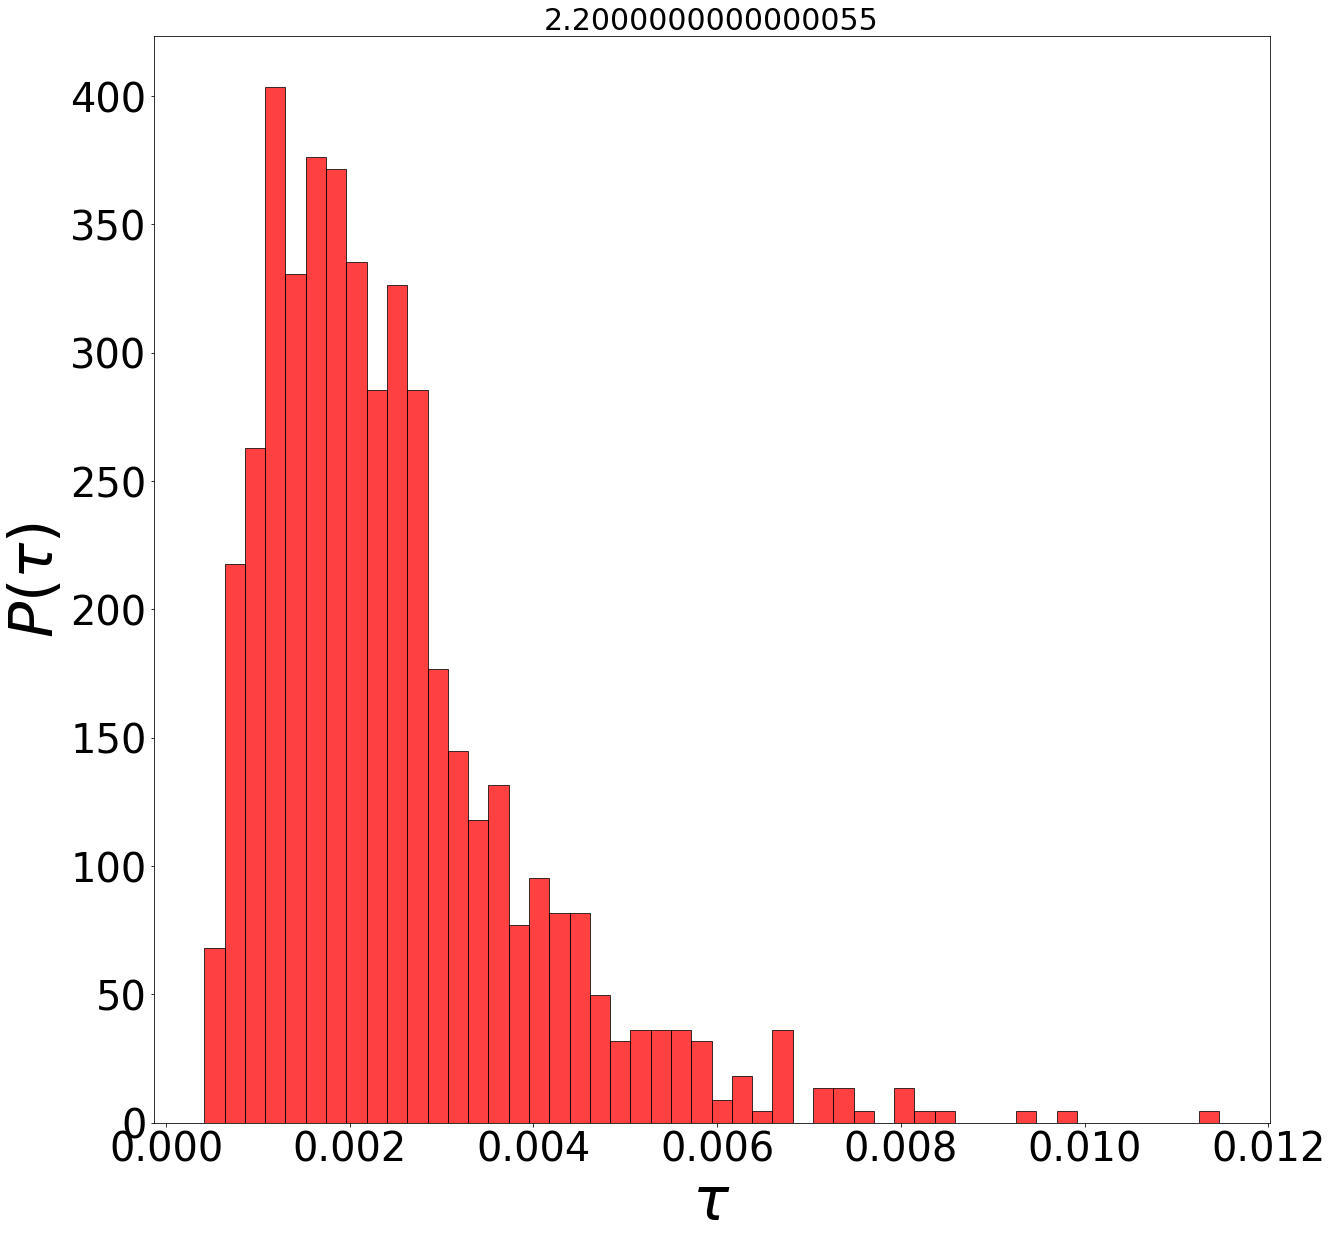

In [66]:
LS, TS = 60, 40
plt.figure(figsize=(20,20))
ax = plt.subplot(111)
indb = -30
ax.set_title(str(boundsB[indb]), size=30)
ax.bar(timbin1[indb], cons1[indb], width=timbin1[indb][1]-timbin1[indb][0], color="red", alpha=0.75, edgecolor="black",)#, label="simulations")
ax.set_xlabel(r'$\tau$',size=LS)
ax.set_ylabel(r'$P(\tau)$', size=LS)
ax.tick_params(axis='both', which='major', labelsize=TS)

In [125]:
len(stop["_1"])

999

In [147]:
nn=0
for k in list(stop["_1"].values()):
    if k != []:
        nn+=1

In [148]:
nn

999